In [2]:
import torch
from torch import optim
import torch.nn as nn
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as album
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
from dataclasses import dataclass
from unet_model import Unet

In [3]:
model = Unet(in_channels=1, number_classes=1)
input = torch.randn([8, 1, 572, 572])
output = model(input)

shape before: torch.Size([8, 1024, 28, 28])
shape after torch.Size([8, 512, 56, 56])
shape before: torch.Size([8, 512, 52, 52])
shape after torch.Size([8, 256, 104, 104])
shape before: torch.Size([8, 256, 100, 100])
shape after torch.Size([8, 128, 200, 200])
shape before: torch.Size([8, 128, 196, 196])
shape after torch.Size([8, 64, 392, 392])


In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [3]:
# create config class for further convenient use
@dataclass
class Config:
    batch_size: int
    epochs: int
    lr: float
    device: "str"

device = "cuda" if torch.cuda.is_available() else "cpu"
config = Config(batch_size=16, epochs=5, lr=3e-4, device=device)
model = Unet(in_channels=3, number_classes=1)

In [4]:
# load data
images, masks = [], []
root = "PH2Dataset"
for root, dirs, files in tqdm(os.walk(os.path.join(root, 'PH2 Dataset images'))):
    if root.endswith('_Dermoscopic_Image'):
        images.append(cv2.imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        masks.append(cv2.imread(os.path.join(root, files[0]), cv2.IMREAD_GRAYSCALE))
print(f"Len of images: {len(images)}")
print(f"Len of masks: {len(masks)}")

801it [00:00, 1565.20it/s]

Len of images: 200
Len of masks: 200


In [5]:
# split data into train, val and test
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.1)
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=0.2)

In [6]:
# create transforms to prepare data to train
transforms = album.Compose([
    album.Normalize(),
    ToTensorV2()
])

In [22]:
# create custom Dataset for our simple task
class PHDataset(Dataset):
    def __init__(self, images, masks, transforms) -> None:
        super().__init__()
        self.images = images
        self.masks = masks
        self.transforms = transforms
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        image = cv2.resize(image, (572, 572))
        mask = self.masks[index] / 255
        mask = cv2.resize(mask, (388, 388))
        sample = self.transforms(image=image, mask=mask)

        return sample

In [23]:
# create train, val and test datasets
train_dataset = PHDataset(train_images, train_masks, transforms)
val_dataset = PHDataset(val_images, val_masks, transforms)
test_dataset = PHDataset(test_images, test_masks, transforms)

In [24]:
# create train, val, and test dataloader
train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=True)

In [1]:
# smth like pl.Trainer :)
class Trainer:
    def __init__(self, model, train_dataloader, val_dataloader, test_dataloader, epochs, lr, device) -> None:
        self.device = device
        self.model = model.to(self.device)
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.test_dataloader = test_dataloader
        self.epochs = epochs
        self.lr = lr
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.lr_scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer=self.optimizer,
            max_lr=self.lr,
            total_steps=len(train_dataloader) * self.epochs + 3,
            epochs=self.epochs,
            div_factor=10
        )
        self.loss = nn.BCELoss()

    def fit(self):
        train_losses = []
        val_losses = []
        for epoch in range(self.epochs):
            # ------------------------------------- TRAIN -------------------------------------
            total_train_loss = 0
            self.model.train()

            print(f"======== Epoch {epoch + 1} / {self.epochs + 1} ========")
            print("Training...")

            for batch in tqdm(self.train_dataloader):
                images = batch["image"].to(self.device)
                target = batch["mask"].to(self.device).unsqueeze(1)

                self.model.zero_grad()

                outputs = self.model(images)
                
                train_loss = self.loss(outputs, target.float())
                total_train_loss += train_loss.item()
                train_loss.backward()

                # torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optimizer.step()
                # self.lr_scheduler.step()
            
            avg_train_loss = total_train_loss / len(self.train_dataloader)
            print(f"Average training loss: {avg_train_loss:.4f}")

            # ------------------------------------- VALIDATION -------------------------------------
            print("Running validation...")
            total_val_loss = 0
            self.model.eval()

            for batch in tqdm(self.val_dataloader):
                images = batch["image"].to(self.device)
                target = batch["mask"].to(self.device).unsqueeze(1)

                with torch.no_grad():
                    outputs = self.model(images)
                
                val_loss = self.loss(outputs, target.float())
                total_val_loss += val_loss.item()
            
            avg_val_loss = total_val_loss / len(self.val_dataloader)
            print(f"Average validation loss: {avg_val_loss:.4f}")

            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)
        
        return train_losses, val_losses

    def test(self, test_dataloader):
        pass

In [ ]:
trainer = Trainer(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    epochs=20,
    lr=1e-4,
    device=config.device
)

In [ ]:
training_stats = trainer.fit()

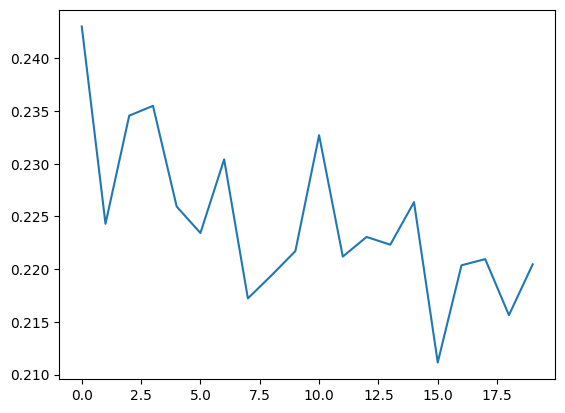

In [83]:
plt.plot(training_stats[0])

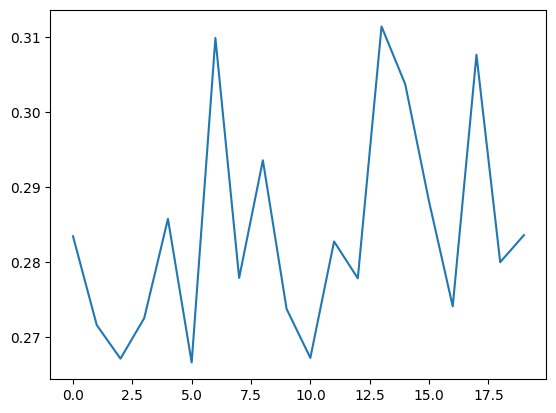

In [84]:
plt.plot(training_stats[1])

In [85]:
min(training_stats[1]), max(training_stats[1])

(0.2666403353214264, 0.31137815117836)

In [86]:
min(training_stats[0]), max(training_stats[0])

(0.21114783154593575, 0.24302187893125746)